In [1]:
!hostname

gl1522.arc-ts.umich.edu


In [2]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from glob import glob
import os
from tqdm import tqdm
import SimpleITK as sitk
import torchio as tio


In [3]:
ROOT = "/home/minsukc/MRI2CT/"
DATA_DIR_ROOT = "/scratch/jjparkcv_root/jjparkcv98/minsukc/"
OUTPUT_DIR = os.path.join(ROOT, "data/")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preprocessing

### Collect data paths

In [4]:
data_dir = os.path.join(DATA_DIR_ROOT, "SynthRAD2025/Task1")
# data_dir = os.path.join(DATA_DIR_ROOT, "SynthRAD2023/Task1")
# print(data_dir)

# Collect MRI, CT, and mask paths
mr_imgs, ct_imgs, masks = [], [], []

for anatomy in sorted(os.listdir(data_dir)):  # AB, HN, TH
    anatomy_path = os.path.join(data_dir, anatomy)
    if not os.path.isdir(anatomy_path):
        continue

    for patient in sorted(os.listdir(anatomy_path)):
        patient_path = os.path.join(anatomy_path, patient)
        if not os.path.isdir(patient_path):
            continue

        mr_path = os.path.join(patient_path, "mr.nii.gz")
        ct_path = os.path.join(patient_path, "ct.nii.gz")
        mask_path = os.path.join(patient_path, "mask.nii.gz")

        if os.path.exists(mr_path) and os.path.exists(ct_path):
            mr_imgs.append(mr_path)
            ct_imgs.append(ct_path)
            if os.path.exists(mask_path):
                masks.append(mask_path)
            else:
                masks.append(None)

print(f"✅ Found {len(mr_imgs)} subjects across all anatomies.")
print(f"Example MRI: {mr_imgs[0]}")

✅ Found 513 subjects across all anatomies.
Example MRI: /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/AB/1ABA005/mr.nii.gz


### Utility functions

In [5]:
def show_middle_slices(vol1, vol2, title1="Original", title2="Cropped"):
    """Show middle axial slices from two 3D volumes for comparison."""
    # Get middle slice index for each volume
    z1 = vol1.shape[-1] // 2
    z2 = vol2.shape[-1] // 2

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.rot90(vol1[..., z1]), cmap="gray")
    plt.title(f"{title1} (z={z1})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.rot90(vol2[..., z2]), cmap="gray")
    plt.title(f"{title2} (z={z2})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
def minmax(arr, minclip=None, maxclip=None):
    if not (minclip is None) & (maxclip is None):
        arr = np.clip(arr, minclip, maxclip)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr

### Show current sampling ratio and resample to target

In [7]:
def get_spacing(path):
    """Return voxel spacing (mm) for a NIfTI file."""
    img = sitk.ReadImage(path)
    return img.GetSpacing()

In [8]:
def resample_volume(in_path, out_path, target_spacing=(1.0, 1.0, 1.0), interp=sitk.sitkLinear, save=True):
    """Resample 3D volume to desired voxel spacing."""
    img = sitk.ReadImage(in_path)
    original_spacing = img.GetSpacing()
    original_size = img.GetSize()

    new_size = [
        int(round(osz * ospc / tspc))
        for osz, ospc, tspc in zip(original_size, original_spacing, target_spacing)
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(target_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(img.GetDirection())
    resample.SetOutputOrigin(img.GetOrigin())
    resample.SetInterpolator(interp)
    resample.SetOutputPixelType(img.GetPixelIDValue())

    new_img = resample.Execute(img)
    if save:
        sitk.WriteImage(new_img, out_path)

    new_array = sitk.GetArrayFromImage(new_img)
    new_array = np.transpose(new_array, (2, 1, 0))  # match nibabel orientation
    return original_spacing, target_spacing, new_array

In [66]:
# ================= CONFIG =================
idx = 250
# idx = 200
# idx = 450
# idx = 400
# idx = 300
# idx = 150
# idx = 120
# idx = 50
# idx = 500
# target_spacing = (1.5, 1.5, 1.5)  # mm³ isotropic
# target_spacing = (2, 2, 2)  # mm³ isotropic
target_spacing = (3, 3, 3)  # mm³ isotropic
save = True
# save = False
# ==========================================

In [67]:
mri_path = mr_imgs[idx]
ct_path = ct_imgs[idx]
mask_path = masks[idx]

print(f"🧩 MRI: {mri_path}")
print(f"🧩 CT : {ct_path}")
print(f"🧩 Mask : {mask_path}")

🧩 MRI: /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA119/mr.nii.gz
🧩 CT : /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA119/ct.nii.gz
🧩 Mask : /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA119/mask.nii.gz


In [68]:
# Original spacings
mri_spacing = get_spacing(mri_path)
ct_spacing = get_spacing(ct_path)
mask_spacing = get_spacing(mask_path)
print(f"📏 Original MRI spacing: {mri_spacing}")
print(f"📏 Original CT  spacing: {ct_spacing}")
print(f"📏 Original CT  spacing: {mask_spacing}")

# Target spacing (customize as needed)
patient_id = os.path.basename(os.path.dirname(mri_path))
spacing_str = "x".join([str(s) for s in target_spacing])  # e.g., "1.5x1.5x3.0"
patient_out_dir = os.path.join(OUTPUT_DIR, f"{patient_id}_{spacing_str}_resampled")
os.makedirs(patient_out_dir, exist_ok=True)

resampled_mri_path = os.path.join(patient_out_dir, "mr_resampled.nii.gz")
resampled_ct_path = os.path.join(patient_out_dir, "ct_resampled.nii.gz")
resampled_mask_path = os.path.join(patient_out_dir, "mask_resampled.nii.gz")

📏 Original MRI spacing: (1.0, 1.0, 3.0)
📏 Original CT  spacing: (1.0, 1.0, 3.0)
📏 Original CT  spacing: (1.0, 1.0, 3.0)


In [69]:
# Resample both
orig_mri_sp, tgt_sp, mri_res = resample_volume(mri_path, resampled_mri_path, target_spacing, save=save)
orig_ct_sp, tgt_sp, ct_res = resample_volume(ct_path, resampled_ct_path, target_spacing, save=save)
orig_mask_sp, tgt_sp, mask_res = resample_volume(mask_path, resampled_mask_path, target_spacing, save=save)
print(f"✅ MRI resampled {orig_mri_sp} → {tgt_sp}")
print(f"✅ CT  resampled {orig_ct_sp} → {tgt_sp}")
print(f"✅ CT  resampled {orig_mask_sp} → {tgt_sp}")

✅ MRI resampled (1.0, 1.0, 3.0) → (3, 3, 3)
✅ CT  resampled (1.0, 1.0, 3.0) → (3, 3, 3)
✅ CT  resampled (1.0, 1.0, 3.0) → (3, 3, 3)


### Visualize before and after resampling

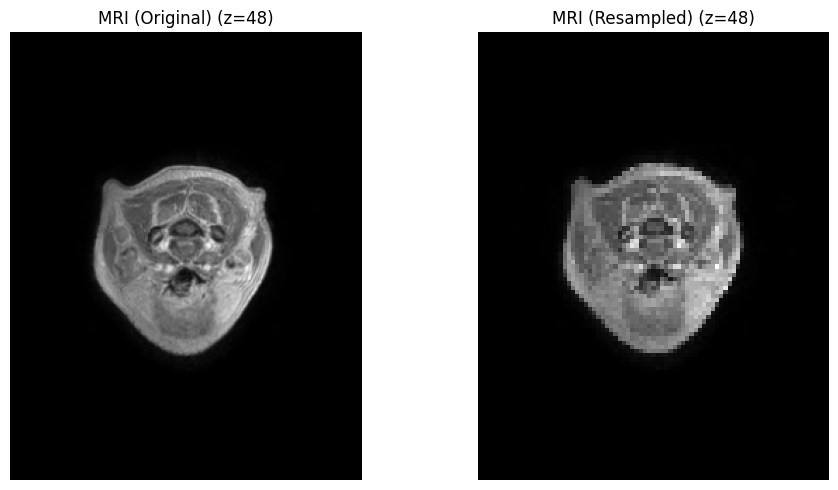

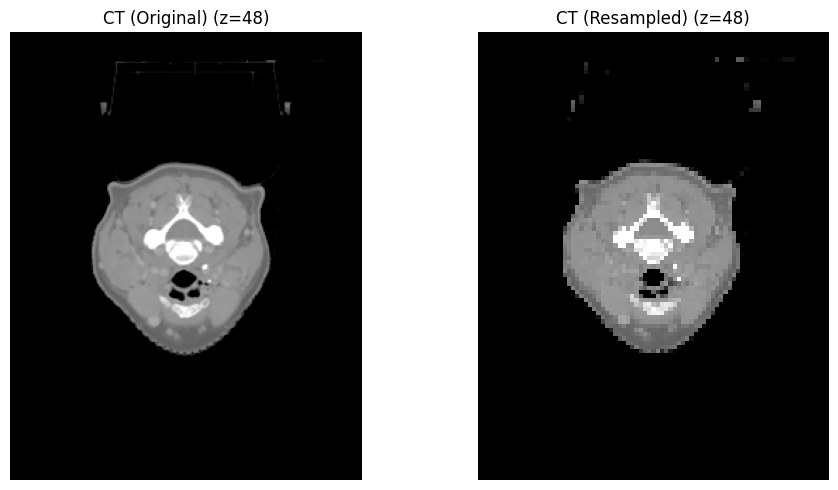

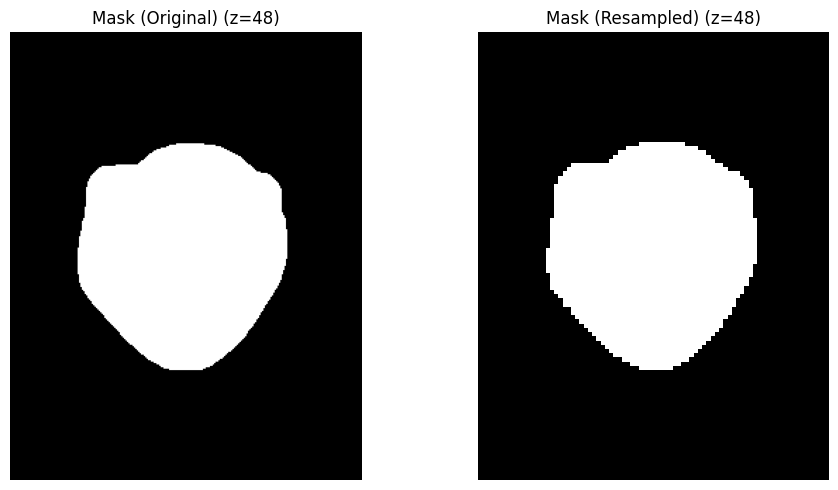

In [70]:
mri_orig = nib.load(mri_path).get_fdata()
mri_orig, mri_res = minmax(mri_orig), minmax(mri_res)

ct_orig = nib.load(ct_path).get_fdata()
ct_orig, ct_res = minmax(ct_orig, -450, 450), minmax(ct_res, -450, 450)

mask_orig = nib.load(mask_path).get_fdata()
mask_orig, mask_res = minmax(mask_orig), minmax(mask_res)

show_middle_slices(mri_orig, mri_res, "MRI (Original)", "MRI (Resampled)")
show_middle_slices(ct_orig, ct_res, "CT (Original)", "CT (Resampled)")
show_middle_slices(mask_orig, mask_res, "Mask (Original)", "Mask (Resampled)")

In [71]:
def compare_volume_size(orig_vol, res_vol, name="Volume"):
    """Print shape and voxel count before and after resampling."""
    orig_shape = orig_vol.shape
    res_shape = res_vol.shape
    orig_voxels = np.prod(orig_shape)
    res_voxels = np.prod(res_shape)
    ratio = res_voxels / orig_voxels

    print(f"🧠 {name}")
    print(f"  • Original shape: {orig_shape}, voxels: {orig_voxels:,}")
    print(f"  • Resampled shape: {res_shape}, voxels: {res_voxels:,}")
    print(f"  • Change ratio: {ratio:.2f}× ({'↑' if ratio>1 else '↓'} compute)\n")
    return ratio

mri_ratio = compare_volume_size(mri_orig, mri_res, "MRI")
ct_ratio  = compare_volume_size(ct_orig, ct_res, "CT")
mask_ratio = compare_volume_size(mask_orig, mask_res, "Mask")

🧠 MRI
  • Original shape: (250, 318, 96), voxels: 7,632,000
  • Resampled shape: (83, 106, 96), voxels: 844,608
  • Change ratio: 0.11× (↓ compute)

🧠 CT
  • Original shape: (250, 318, 96), voxels: 7,632,000
  • Resampled shape: (83, 106, 96), voxels: 844,608
  • Change ratio: 0.11× (↓ compute)

🧠 Mask
  • Original shape: (250, 318, 96), voxels: 7,632,000
  • Resampled shape: (83, 106, 96), voxels: 844,608
  • Change ratio: 0.11× (↓ compute)



In [72]:
print(f"🧠 Resampled volumes saved to: {patient_out_dir}")

🧠 Resampled volumes saved to: /home/minsukc/MRI2CT/data/1HNA119_3x3x3_resampled
